In [1]:
import sys
import os
import os.path
import fnmatch
from lxml import etree
from lxml.etree import tostring
import re
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pylab import plot
import pickle
import re
import matplotlib.patches as mpatches
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def process_files(list_of_files, path_in):
    
    words_dict=defaultdict(list)
    length_dict=defaultdict(list)
    chaps_dict=defaultdict(list)
    divs_dict=defaultdict(list)
    first_dict=defaultdict(list)
    last_dict=defaultdict(list)
    first_ent_dict=defaultdict(list)
    last_ent_dict=defaultdict(list)
    plot_words=OrderedDict()
    plot_chaps=OrderedDict()
    plot_div1=OrderedDict()
    plot_div2=OrderedDict()
    plot_div3=OrderedDict()
    plot_length=OrderedDict()
    plot_first=OrderedDict()
    plot_last=OrderedDict()
    plot_ent_first=OrderedDict()
    plot_ent_last=OrderedDict()
    filtered=list()
    bugs=list()
    stats=defaultdict(list)
    
    print("Processing "+str(len(list_of_files))+" files. Please wait, this might take some time.")

    for tmpFile in list_of_files:

        tmpFile=tmpFile.replace("/",":")
        fullPath=path_in+tmpFile

        print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)

        #yearKey=int(tmpFile[:3]+"0")
            yearKey=int(tmpFile[:4])

            words_dict=num_words(words_dict,tree, yearKey, bugs, tmpFile)
            #print(words_dict.keys())
            chaps_dict=num_chapters(chaps_dict,tree,yearKey, bugs,tmpFile)
            
            divs_dict=num_divs(divs_dict, tree, yearKey, bugs, tmpFile)
            
            length_dict=length(length_dict, tree.getroot(), yearKey)
            
            first_dict=num_first(first_dict, tree, yearKey, tmpFile)
            
            last_dict=num_last(last_dict, tree, yearKey, tmpFile)
            
            first_ent_dict=num_ent_first(first_ent_dict, tree, yearKey, tmpFile)
            
            last_ent_dict=num_ent_last(last_ent_dict, tree, yearKey, tmpFile)
            

    plot_words=words_for_plot(words_dict, plot_words)
    plot_chaps=words_for_plot(chaps_dict, plot_chaps)
    plot_length=words_for_plot(length_dict, plot_length)
    plot_div1=divs_for_plot(divs_dict, plot_div1,1)
    plot_div2=divs_for_plot(divs_dict, plot_div2,2)
    plot_div3=divs_for_plot(divs_dict, plot_div3,3)
    plot_first=words_for_plot(first_dict, plot_first)
    plot_last=words_for_plot(last_dict, plot_last)
    plot_ent_first=words_for_plot(first_ent_dict, plot_ent_first)
    plot_ent_last=words_for_plot(last_ent_dict, plot_ent_last)
    #print(bugs)
    fit_words = lin_reg(plot_words)
    fit_chaps = lin_reg(plot_chaps)
    
    print(first_dict)
    print(last_dict)
    
    stats["chapter"].append(fit_chaps)
    stats["chapter"].append(plot_chaps)
    stats["word"].append(fit_words)
    stats["word"].append(plot_words)
    stats["divs"].append(plot_div1)
    stats["divs"].append(plot_div2)
    stats["divs"].append(plot_div3)
    stats["length"].append(plot_length)
    stats["exts"].append(plot_first)
    stats["exts"].append(plot_last)
    stats["ents"].append(plot_ent_first)
    stats["ents"].append(plot_ent_last)
    
    return stats

    #del filtered
    del words_dict
    del chaps_dict
    del plot_words
    del plot_chaps

In [3]:
def lin_reg(series):

    x = np.array(list(series.keys()))
    y = np.array(list(series.values()))

    x = sm.add_constant(x)

    return sm.OLS(y, x).fit()

In [4]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [5]:
def plot_stats (fit, plot,limitsX,limitsY, sliding, mycolor, title):
    x1 = list(plot.keys())[0]
    x2 = list(plot.keys())[-1]
    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    #print(len(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.figure(figsize=(10, 6))
    plt.plot(list(plot.keys()), list(plot.values()))
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.title(title)
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    #plt.xlim(min(plot.keys()),max(plot.keys()))
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    #print(plot.keys())
    plt.show()

In [6]:
def simple_plot (plot, limitsX, limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.plot(x,y)
    plt.title(title)
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.show()

In [30]:
def multiple_plots (min_year, max_year, nb_words, nb_words_chap, stats):
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['word'][1].keys()))
        y=np.array(list(stats[name]['word'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(min(stats[name]['word'][1].keys()),nb_words)
        plt.xlim(min_year, max_year)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de mots par chapitre")
    plt.show()
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['chapter'][1].keys()))
        y=np.array(list(stats[name]['chapter'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(0,nb_words_chap)
        plt.xlim(min_year, max_year)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de chapitres")
    plt.show()

In [8]:
def hierarchy_plots (plot,limitsX,limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot[0].keys()))
    y = np.array(list(plot[0].values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=2,color=mycolor[0])
    x1 = np.array(list(plot[1].keys()))
    y1 = np.array(list(plot[1].values()))
    yMA1 = movingaverage(y1,sliding)
    plt.plot(x1[len(x1)-len(yMA1):],yMA1,linewidth=2,color=mycolor[1])
    x2 = np.array(list(plot[2].keys()))
    y2 = np.array(list(plot[2].values()))
    yMA2 = movingaverage(y2,sliding)
    plt.plot(x2[len(x2)-len(yMA2):],yMA2,linewidth=2,color=mycolor[2])
    plt.legend(loc='upper left')
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.title(title)
    patch1 = mpatches.Patch(color=color[0], label='niveau 1')
    patch2 = mpatches.Patch(color=color[1], label='niveau 2')
    patch3 = mpatches.Patch(color=color[2], label='niveau 3')
    plt.legend(handles=[patch1, patch2, patch3])
    plt.show()

In [9]:
def first_n_last_plots (plot,limitsX,limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot[0].keys()))
    y = np.array(list(plot[0].values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=2,color=mycolor[0])
    x1 = np.array(list(plot[1].keys()))
    y1 = np.array(list(plot[1].values()))
    yMA1 = movingaverage(y1,sliding)
    plt.plot(x1[len(x1)-len(yMA1):],yMA1,linewidth=2,color=mycolor[1])
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.legend(loc='upper left')
    plt.title(title)
    patch1 = mpatches.Patch(color=color[0], label='first')
    patch2 = mpatches.Patch(color=color[1], label='last')
    
    plt.legend(handles=[patch1, patch2])
    plt.show()

In [10]:
def num_words (words_dict,tree,yearKey,bugs,tmpFile):
    execute=False
    words=list()
    if tree.findall(".//div[@type='chapter']"):
        for chapter in tree.findall(".//div[@type='chapter']"):
            numWords=len(chapter.findall(".//word"))
            words.append(numWords)
            execute=True
    elif tree.findall(".//div[@type='part']"):
        for chapter in tree.findall(".//div[@type='part']"):
            numWords=len(chapter.findall(".//word"))
            words.append(numWords)
            execute=True
    
    else :
        for p in tree.findall(".//p"):
            numWords=len(p.findall(".//word"))
            words.append(numWords)
            execute=True
    
    if execute==True:
        average=sum(words)/len(words)
        words_dict[yearKey].append(average)
    return words_dict

In [11]:
def length (length_dict, node, yearKey):
    length_dict[yearKey].append(len(node.findall(".//word")))
    return length_dict

In [12]:
def num_chapters (chaps_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']"):
        num_chaps=len(tree.findall(".//div[@type='chapter']"))
        execute=True
    elif tree.findall(".//div[@type='part']"):
        num_chaps=len(tree.findall(".//div[@type='part']"))
        execute=True
    
    else :
        bugs.append(tmpFile+" ; ")
        execute=False
    
    if execute==True:
        chaps_dict[yearKey].append(num_chaps)
        
    else :
        chaps_dict[yearKey].append(0)
    return chaps_dict

In [13]:
def num_divs (divs_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']") and tree.findall(".//div[@type='book']"):
        num_divs=3
    elif tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']"):
        num_divs=2
    elif tree.findall(".//div[@type='chapter']") or tree.findall(".//div[@type='part']" or tree.findall(".//div[@type='book']")):
        num_divs=1
    else :
        num_divs=0
    
    divs_dict[yearKey].append(num_divs)
    
    return divs_dict

In [14]:
def num_first (ext_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[0].findall(".//word"))
        ext_dict[yearKey].append(ext1)
        if ext1==0:
            print ("Problem (first chap) with file : "+file)
    return ext_dict

In [15]:
def num_ent_first (ext_ent_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[0].xpath(".//word[starts-with(@postag, 'NAME')]"))
        if (ext1>1000):
            if 'title' in chaps[0].attrib:
                print(chaps[0].attrib['title'])
            print(ext1)
        ext_ent_dict[yearKey].append(ext1)
    return ext_ent_dict

In [16]:
def num_last (ext_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext2=len(chaps[len(chaps)-1].findall(".//word"))
        ext_dict[yearKey].append(ext2)
        if ext2==0:
            print ("Problem (last chap) with file : "+file)
    return ext_dict

In [17]:
def num_ent_last (ext_ent_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[len(chaps)-1].xpath(".//word[starts-with(@postag, 'NAME')]"))
        ext_ent_dict[yearKey].append(ext1)
    return ext_ent_dict

In [18]:
def words_for_plot (words_dict, plot_words):
    for year in sorted(words_dict.keys()):
        if len(words_dict[year])>0:
        #moyenne nombre de mots par année
            plot_words[year]=sum(words_dict[year])/len(words_dict[year])
    return plot_words

In [19]:
def divs_for_plot (divs_dict, plot_divs, hierarchy):
    for year in sorted(divs_dict.keys()):
        plot_divs[year]=divs_dict[year].count(hierarchy)
    return plot_divs

In [20]:
def by_attribute (list_of_files, path_in, lxml_string):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                filtered.append(tmpFile)
    return filtered

In [21]:
def by_element_value (list_of_files, path_in, lxml_string, value_to_check):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                for elem in tree.findall(lxml_string):
                    if elem.text and value_to_check in elem.text:
                        filtered.append(tmpFile)
    return filtered

In [22]:
def by_name (list_of_files, path_in, author):
    files_by_author=list()
    for tmpFile in list_of_files:
        fullPath=path_in+tmpFile.replace("/",":")
        if os.path.isfile(fullPath):
            result = re.search('[0-9]{4}(.*)_', tmpFile)
            name= result.group(1)
            if author in name:
                files_by_author.append(tmpFile)
    return files_by_author

In [58]:
%matplotlib inline
path_to_folder='/home/odysseus/Bureau/ANR/corpus/tagged_corp/'
#path_to_folder='/home/odysseus/Bureau/ANR/romans/'
authors=['_Dumas','_Zola','_Guy-de-Maupassant','_Sand-G',"_Simenon","_San-Antonio","_Leblanc"]

print("Statistiques globales : ")
files_list=fnmatch.filter(os.listdir(path_to_folder), '*.xml')

#stats_authors=OrderedDict()
#for author in authors:
    #names=by_name(files_list, path_to_folder,author)
    #stats_authors[author]=process_files(names, path_to_folder)
#pickle.dump(stats_authors, open("stats_authors","wb"))
    
#stats_global=process_files(files_list, path_to_folder)

canon_list=by_attribute(files_list, path_to_folder,".//profileDesc[@tag='non-canon']")
stats_canon=process_files(canon_list, path_to_folder)

#genre_list=by_element_value(files_list, path_to_folder,".//term","populaire")
#stats_genre=process_files(genre_list, path_to_folder)

#pickle.dump(stats_global, open("stats_rest","wb"))
#pickle.dump(stats_canon, open("stats_rest_canon","wb"))
#pickle.dump(stats_genre, open("stats_rest_populaire","wb"))

#pickle.dump(stats_global, open("stats_global","wb"))
pickle.dump(stats_canon, open("stats_global_non-canon","wb"))
#pickle.dump(stats_genre, open("stats_global_populaire","wb"))

Statistiques globales : 
Processing 1348 files. Please wait, this might take some time.

Processing file 2013_Stolz-Madame-de_Les-Poches-de-mon-oncle.xml

Processing file 1861_Gondrecourt-Aristide-de_Le-Pays-de-la-peur-par-A-de-Gondrecourt-Tome-2-(1861).xml
Problem (first chap) with file : 1861_Gondrecourt-Aristide-de_Le-Pays-de-la-peur-par-A-de-Gondrecourt-Tome-2-(1861).xml
Problem (last chap) with file : 1861_Gondrecourt-Aristide-de_Le-Pays-de-la-peur-par-A-de-Gondrecourt-Tome-2-(1861).xml

Processing file 1882_Hericault-Charles-d-_Les-Bourgeois-de-93--La-Fille-de-Notre-Dame-par-Ch-d-Hericault-(1882).xml
Problem (first chap) with file : 1882_Hericault-Charles-d-_Les-Bourgeois-de-93--La-Fille-de-Notre-Dame-par-Ch-d-Hericault-(1882).xml

Processing file 1909_Boylesve-Rene_La-jeune-fille-bien-elevee.xml

Processing file 1861_Erckmann-Chatrian_Confidences-d-un-joueur-de-clarinette.xml

Processing file 1920_Toulet-Paul-Jean_La-jeune-fille-verte-roman.xml

Processing file 1961_Troyat-Henri


Processing file 2002_Jourde-Pierre_Pays-perdu.xml

Processing file 1904_Gautier-Judith_Le-paravent-de-soie-et-d-or.xml

Processing file 1918_Gustave-Le-Rouge-de-Brisay-Henri_L-Heroine-du-Colorado.xml

Processing file 2013_Guaita-Stanislas-de_Rosa-mystica.xml

Processing file 2007_Pennac-Daniel_Chagrin-d-ecole.xml
Problem (first chap) with file : 2007_Pennac-Daniel_Chagrin-d-ecole.xml
Problem (last chap) with file : 2007_Pennac-Daniel_Chagrin-d-ecole.xml

Processing file 1882_Uchard-Mario_La-Buveuse-de-perles-par-Mario-Uchard-(1882).xml

Processing file 1921_Leblanc-Maurice_Le-Formidable-Evenement.xml

Processing file 2010_Gavalda-Anna_Desordre-et-Sentiments.xml

Processing file 1980_Siniac-Pierre_L-unijambiste-de-la-cote-284.xml

Processing file 1913_Le-Rouge-Gustave_Le-Mysterieux-Docteur-Cornelius-Tome-I.xml

Processing file 1943_Barjavel-Rene_Ravage.xml

Processing file 2013_Pont-Jest-Rene-de_Bolino-le-negrier-souvenirs-de-l-Ocean-Indien.xml

Processing file 1895_Lermina-Jules_L-eni


Processing file 1891_Malot-Hector_Anie.xml

Processing file 1897_Allais-Alphonse_Le-bec-en-l-air.xml

Processing file 1882_Macaire-Robert-_Memoires-de-Robert-Macaire-ecrits-par-lui-meme-(1882).xml

Processing file 1869_Stolz-Madame-de_La-Maison-roulante.xml

Processing file 1925_Leroux-Gaston_Les-Tenebreuses-I.xml

Processing file 1962_San-Antonio_Fleur-de-nave-vinaigrette.xml

Processing file 1962_San-Antonio_Le-loup-habille-en-grand-mere.xml

Processing file 1953_San-Antonio_Des-dragees-sans-bapteme.xml

Processing file 2013_Fleuriot-Zenaide_Tranquille-et-Tourbillon.xml

Processing file 1922_Leblanc-Maurice_Le-Cercle-rouge.xml

Processing file 1880_Stapleaux-Leopold_Le-pendu-de-la-Foret-Noire-(1880).xml

Processing file 1877_Feuillet-Octave_Les-amours-de-Philippe-(1877).xml
Problem (first chap) with file : 1877_Feuillet-Octave_Les-amours-de-Philippe-(1877).xml

Processing file 1876_Aimard-Gustave_L-Olonnais.xml

Processing file 1961_San-Antonio_Ne-mangez-pas-la-consigne.xml

Process


Processing file 1992_Hemon-Louis_Ecrits-sur-le-Quebec.xml

Processing file 1862_Malot-Hector_Les-Amants.xml

Processing file 1956_San-Antonio_Les-doigts-dans-le-nez.xml

Processing file 1888_Larmandie-Leonce-de_Excelsior-Roman-parisien.xml

Processing file 1926_Leroux-Gaston_Le-fils-de-trois-peres-Hardigras.xml

Processing file 1897_Rodenbach-Georges_Le-Carillonneur.xml

Processing file 1894_Vanderem-Fernand_La-Cendre-Roman.xml

Processing file 1867_Gaboriau-Emile_Les-Esclaves-de-Paris-Tome-I.xml

Processing file 1868_Perret-Paul_La-Parisienne.xml

Processing file 1853_Desnoiresterres-Gustave_Un-amour-en-diligence.xml

Processing file 1901_Boylesve-Rene_La-Becquee.xml

Processing file 1991_Boileau-Narcejac_La-main-passe.xml

Processing file 1899_Boylesve-Rene_Mademoiselle-Clocque.xml

Processing file 1917_Boylesve-Rene_Le-Bonheur-a-cinq-sous.xml

Processing file 1891_Graffigny-H-de-Le-Faure-Georges_Aventures-Extraordinaires-d-un-Savant-Russe-Tome-III-Les-Planetes-Geantes-et-les-Comete


Processing file 1977_San-Antonio_Remet-ton-slip-gondolier.xml

Processing file 1888_Rosny-aine-J-H_Les-Corneilles.xml

Processing file 1933_Leblanc-Maurice_Victor-de-la-Brigade-mondaine.xml

Processing file 1888_Boisgobey-Fortune-du_L-Oeil-de-chat-Tome-premier.xml

Processing file 1974_A.D.G._Je-suis-un-roman-noir.xml

Processing file 1892_Greville-Henry_Chenerol.xml

Processing file 1893_Malot-Hector_En-Famille.xml

Processing file 1884_Boisgobey-Fortune-du_La-voilette-bleue.xml

Processing file 1920_Allais-Alphonse_a-l-oeil.xml

Processing file 2013_Bastide-Jenny_Le-Marquis-Roger.xml

Processing file 2000_Grange-Jean-Christophe_Le-concile-de-pierre.xml

Processing file 1897_Mary-Jules_Les-Filles-de-la-pocharde.xml

Processing file 2004_Bouraoui-Nina_Poupee-Bella.xml

Processing file 1878_Ulbach-Louis_Monsieur-Paupe-par-Louis-Ulbach-(1878).xml
Problem (first chap) with file : 1878_Ulbach-Louis_Monsieur-Paupe-par-Louis-Ulbach-(1878).xml
Problem (last chap) with file : 1878_Ulbach-Loui


Processing file 1889_Bazin-Rene_Les-Noellet.xml

Processing file 1882_Toudouze-Gustave_Gustave-Toudouze-La-Seductrice-roman-parisien-(1882).xml

Processing file 1920_Leroux-Gaston_Rouletabille-chez-Krupp.xml

Processing file 1870_Houssaye-Arsene_Arsene-Houssaye-Les-Courtisanes-du-monde-(1870).xml

Processing file 1997_Grange-Jean-Christophe_Les-rivieres-pourpres.xml

Processing file 2014_Bouraoui-Nina_Standard.xml

Processing file 1887_Adam-Paul_La-glebe.xml

Processing file 1882_Cadol-Edouard_Son-Excellence-Satinette-(affaires-etrangeres)-par-Edouard-Cadol-(1882).xml

Processing file 1878_Greville-Henry_Les-epreuves-de-Raissa.xml

Processing file 1973_Barjavel-Rene_Le-Grand-Secret.xml
I
1051

Processing file 1882_Montesquiou-Fezensac-Robert-de_La-petite-mademoiselle.xml

Processing file 1893_Allais-Alphonse_Le-parapluie-de-l-escouade.xml

Processing file 1960_San-Antonio_Du-sirop-pour-les-guepes.xml

Processing file 1889_Lemonnier-Camille_Ceux-de-la-glebe.xml

Processing file 1865_Po


Processing file 1951_San-Antonio_Les-souris-ont-la-peau-tendre.xml

Processing file 1876_Aimard-Gustave_Le-Chasseur-de-rats-Tome-2-Le-commandant-Delgres.xml

Processing file 1991_Vargas-Fred_L-homme-aux-cercles-bleus.xml

Processing file 1898_Boylesve-Rene_Le-parfum-des-iles-Borromees.xml
Problem (first chap) with file : 1898_Boylesve-Rene_Le-parfum-des-iles-Borromees.xml

Processing file 2008_Gavalda-Anna_La-consolante.xml
Start
3652

Processing file 2015_Forest-Philippe_Aragon.xml

Processing file 1876_Gaboriau-Emile_Le-petit-vieux-des-Batignolles.xml

Processing file 1959_San-Antonio_Entre-la-vie-et-la-morgue.xml

Processing file 1870_Gaboriau-Emile_La-clique-doree.xml

Processing file 1955_Laurent-Jacques_Caroline-Cherie-T.2.xml

Processing file 2003_Rufin-Jean-Christophe_Globalia.xml

Processing file 1863_Feval-Paul-(pere)_La-Fille-du-Juif-Errant.xml

Processing file 1924_Hemon-Louis_Colin-Maillard.xml

Processing file 1904_Eekhoud-Georges_L-Autre-vue.xml

Processing file 1898_Ma


Processing file 1917_Bernede-Arthur_Judex.xml

Processing file 1903_Adam-Paul_Au-soleil-de-juillet-(1829-1830).xml

Processing file 2007_Gailly-Christian_Les-Oublies.xml

Processing file 1888_Lesueur-Daniel_Amour-d-aujourd-hui.xml

Processing file 1890_Pitray-Olga-de-Segur_Voyages-abracadabrants-du-gros-Phileas.xml

Processing file 1871_Feval-Paul-(pere)_Le-dernier-vivant-II.xml

Processing file 1886_Carraud-Zulma-Tourangin-Mme_Contes-et-historiettes.xml

Processing file 1914_Zevaco-Michel_La-Reine-Sanglante.xml

Processing file 1882_Ohnet-Georges_Le-Maitre-de-forges.xml

Processing file 1959_San-Antonio_San-Antonio-met-le-paquet.xml

Processing file 1867_Ponson-du-Terrail-Pierre_La-Verite-sur-Rocambole.xml

Processing file 1882_Zaccone-Pierre_La-Recluse.xml

Processing file 1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-2).xml

Processing file 1986_Daeninckx-Didier_Lumiere-noire.xml

Processing file 2013_Pressense-Elise-de_Un-petit-mo


Processing file 1881_Racot-Adolphe_Le-Plan-d-Helene-par-Adolphe-Racot-(1881).xml

Processing file 1854_Karr-Alphonse_Histoire-d-un-pion.xml

Processing file 1934_Dabit-Eugene_Un-mort-tout-neuf.xml

Processing file 2011_Angot-Christine_Une-semaine-de-vacances.xml
Problem (first chap) with file : 2011_Angot-Christine_Une-semaine-de-vacances.xml

Processing file 1851_Souvestre-Emile_Les-derniers-paysans-Tome-2.xml
Problem (first chap) with file : 1851_Souvestre-Emile_Les-derniers-paysans-Tome-2.xml
Problem (last chap) with file : 1851_Souvestre-Emile_Les-derniers-paysans-Tome-2.xml

Processing file 1890_Allais-Alphonse_a-se-tordre.xml

Processing file 1999_Vargas-Fred_L-homme-a-l-envers.xml

Processing file 1868_Erckmann-Chatrian_Histoire-d-un-paysan-I.xml

Processing file 1879_Lebourgeois-Marie_La-Goutte-de-miel-par-Mlle-Marie-Le-Bourgeois-(1879).xml

Processing file 2013_Erckmann-Chatrian_Contes-fantastiques.xml

Processing file 1852_Carraud-Zulma-Tourangin-Mme_La-petite-Jeanne.xml

Pr

Problem (last chap) with file : 1879_Bouvier-Alexis_La-femme-du-mort-Tome-II.xml

Processing file 1897_Lemonnier-Camille_L-homme-en-amour.xml

Processing file 1957_San-Antonio_En-long-en-large-et-en-travers.xml

Processing file 2007_Chandernagor-Françoise_La-voyageuse-de-la-nuit.xml

Processing file 1909_Zevaco-Michel_Le-Pont-des-soupirs.xml

Processing file 1867_Pressense-Elise-de_Deux-ans-au-lycee-(1867).xml
Problem (last chap) with file : 1867_Pressense-Elise-de_Deux-ans-au-lycee-(1867).xml

Processing file 2013_Gouraud-Julie_Les-Filles-du-professeur.xml

Processing file 2005_Begaudeau-François_Un-democrate-Mick-Jagger.xml
Page titre
1024

Processing file 2001_Calet-Henri_Poussieres-de-la-route.xml

Processing file 1872_Gaboriau-Emile_La-Degringolade-Tome-3.xml

Processing file 1873_Malot-Hector_Clotilde-Martory.xml

Processing file 1877_Beaugrand-Honore_Jeanne-la-fileuse.xml

Processing file 1969_Siniac-Pierre_La-Nuit-des-Auverpins.xml

Processing file 1908_Zevaco-Michel_La-Fausta.


Processing file 2001_Gaude-Laurent_Cris.xml

Processing file 1856_Ponson-du-Terrail-Pierre_L-Heritage-Mysterieux.xml

Processing file 1950_San-Antonio_Reglez-lui-son-compte-.xml

Processing file 1833_Musset-Alfred-de_Gamiani-ou-Deux-Nuits-d-Exces.xml

Processing file 2013_Pont-Jest-Rene-de_Fire-fly-Souvenirs-des-Indes-et-de-la-Chine.xml

Processing file 1991_Sagan-Françoise_Les-Faux-fuyants.xml

Processing file 1930_Leblanc-Maurice_Le-prince-de-Jericho.xml

Processing file 1863_Capendu-Ernest_Marcof-Le-Malouin.xml

Processing file 1917_Nadaud-Marcel_Chignole-(la-guerre-aerienne).xml

Processing file 1897_Mary-Jules_La-Pocharde.xml

Processing file 1842_Feval-Paul-(pere)_Les-Mysteres-de-Londres-Tome-I.xml

Processing file 1954_San-Antonio_Deuil-express.xml

Processing file 1897_Bazin-Rene_De-toute-son-ame.xml

Processing file 1934_Duhamel-Georges_Vue-de-la-terre-promise.xml

Processing file 1981_Pagnol-Marcel_Confidences.xml

Processing file 2005_Bouraoui-Nina_Mes-mauvaises-pensees.xml


Processing file 1862_Feval-Paul-(pere)_Les-habits-noirs-Tome-I.xml

Processing file 1893_Courteline-Georges_Messieurs-les-ronds-de-cuir.xml

Processing file 2003_Beigbeder-Frederic_Windows-on-the-World.xml

Processing file 1840_Eyma-Xavier_Le-Medaillon.xml

Processing file 2009_Viel-Tanguy_Paris-Brest.xml

Processing file 1961_San-Antonio_La-fin-des-haricots.xml

Processing file 1998_Gailly-Christian_La-Passion-de-Martin-Fissel-Brandt.xml

Processing file 2000_Claudel-Philippe_J-abandonne.xml

Processing file 1879_Belot-Adolphe_La-Grande-Florine-suite-et-fin-des-Etrangleurs-par-Adolphe-Belot-(1879).xml
Problem (first chap) with file : 1879_Belot-Adolphe_La-Grande-Florine-suite-et-fin-des-Etrangleurs-par-Adolphe-Belot-(1879).xml

Processing file 1970_Blondin-Antoine_Monsieur-Jadis-ou-l-ecole-du-soir.xml

Processing file 1983_Daeninckx-Didier_Le-Geant-Inacheve.xml
[1]
1544

Processing file 2006_Le-Linda_In-memoriam.xml

Processing file 1879_Greville-Henry_Bonne-Marie.xml

Processing fil


Processing file 1963_Pagnol-Marcel_Manon-des-sources.xml

Processing file 1985_Barjavel-Rene_La-peau-de-Cesar.xml

Processing file 1900_Beaugrand-Honore_La-chasse-galerie.xml

Processing file 1858_Ponson-du-Terrail-Pierre_Les-Exploits-de-Rocambole-Tome-II-La-Mort-du-sauvage.xml

Processing file 1892_Rodenbach-Georges_Bruges-la-Morte.xml

Processing file 1878_Malot-Hector_Sans-famille.xml

Processing file 1846_Erckmann-Jules_Les-Disciples-d-Escobar.xml

Processing file 1873_Gaboriau-Emile_La-Degringolade-Tome-1.xml

Processing file 1975_San-Antonio_Certaines-l-aiment-chauve.xml

Processing file 1877_Chavannes-de-La-Giraudiere-Hippolyte-de_Patrice-ou-Les-pionniers-de-l-Amerique-du-Nord.xml

Processing file 1919_Leblanc-Maurice_L-ile-aux-Trente-cercueils.xml

Processing file 1850_Feval-Paul-(pere)_Les-Belles-de-nuit-ou-Les-Anges-de-la-famille-Tome-I.xml

Processing file 1969_Sagan-Françoise_Un-peu-de-soleil-dans-l-eau-froide.xml

Processing file 1915_Leblanc-Maurice_L-eclat-d-obus.xml

P

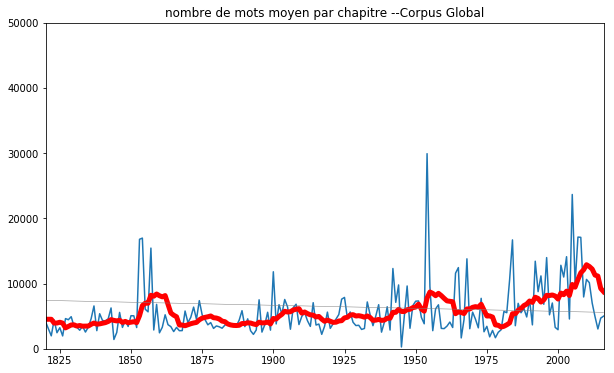

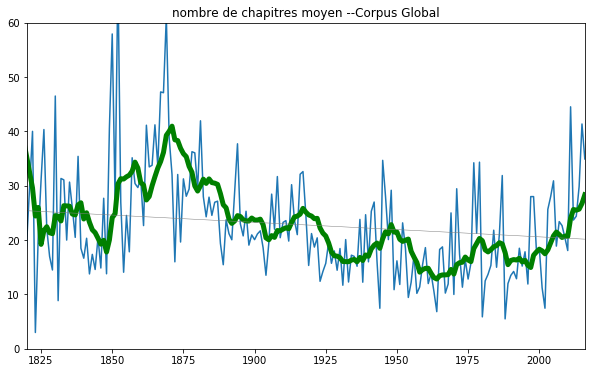

In [53]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1820,2016]
limitsWord=[0,50000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre --Corpus Global")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen --Corpus Global")

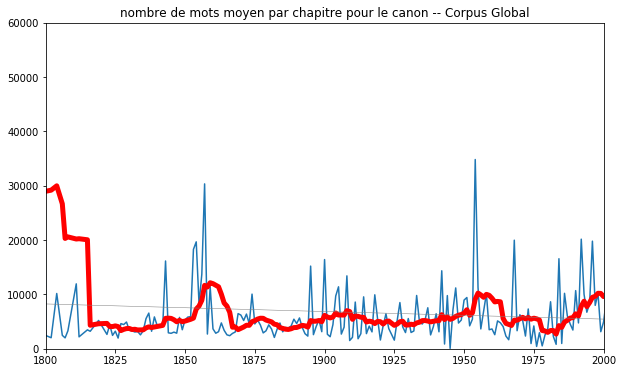

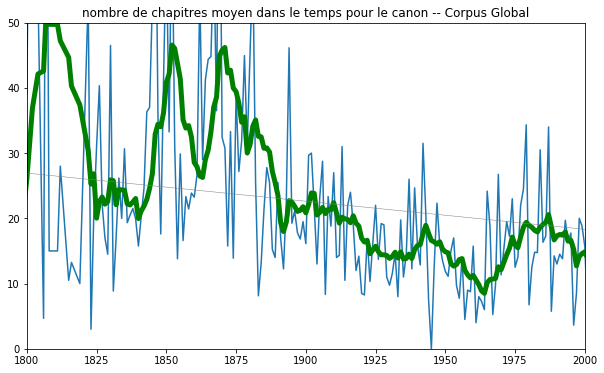

In [56]:
stats_canon=pickle.load(open( "stats_global_canon", "rb"))
limitsX=[1800,2000]
limitsWord=[0,60000]
limitsChap=[0,50]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre pour le canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps pour le canon -- Corpus Global")

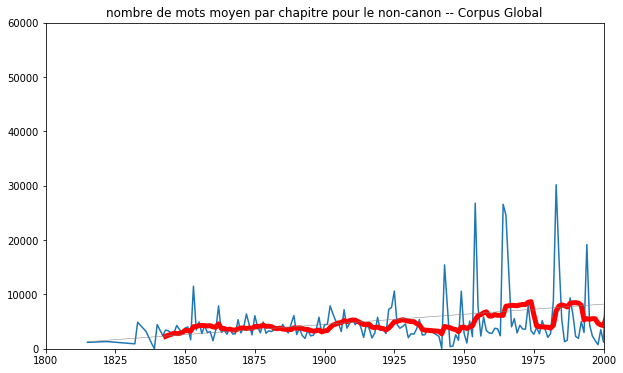

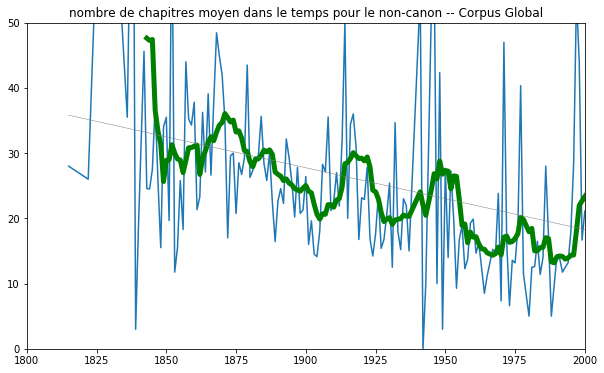

In [60]:
stats_canon=pickle.load(open( "stats_global_non-canon", "rb"))
limitsX=[1800,2000]
limitsWord=[0,60000]
limitsChap=[0,50]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre pour le non-canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps pour le non-canon -- Corpus Global")

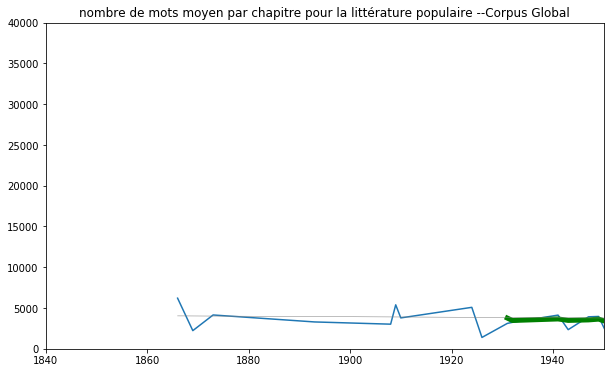

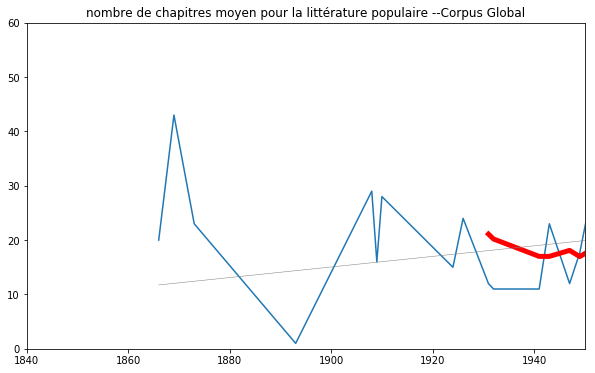

In [19]:
stats_canon=pickle.load(open( "stats_rest_policier", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Global")

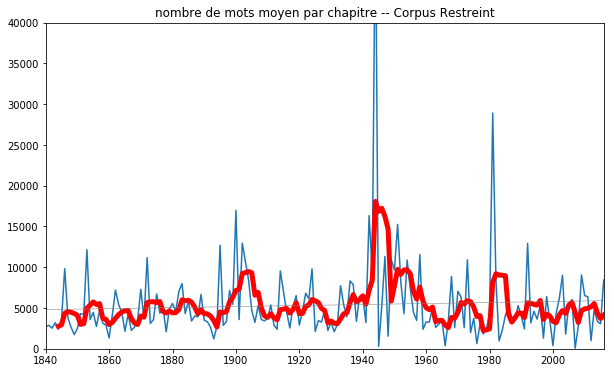

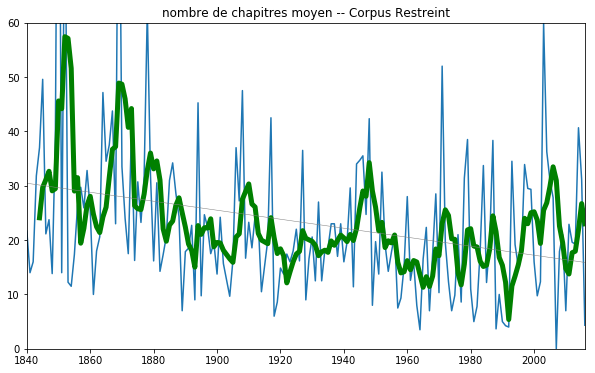

In [24]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=5
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre -- Corpus Restreint")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen -- Corpus Restreint")

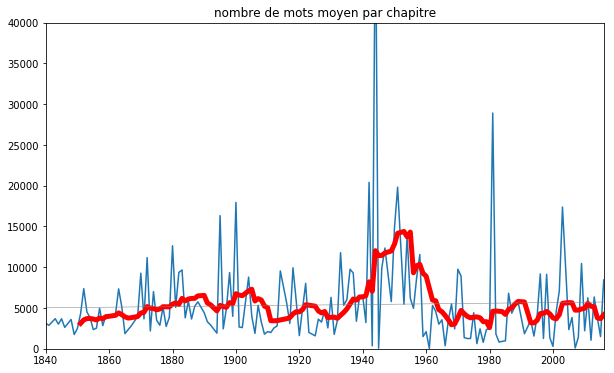

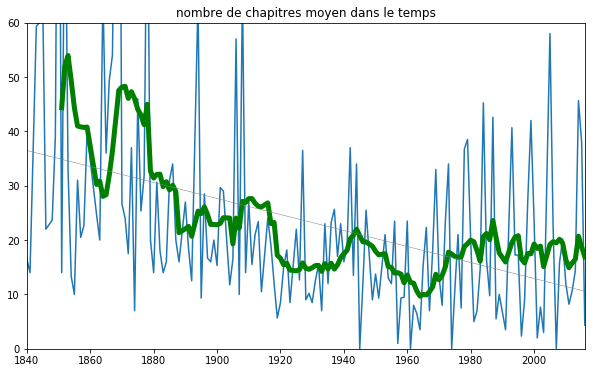

In [40]:
stats_canon=pickle.load(open( "stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

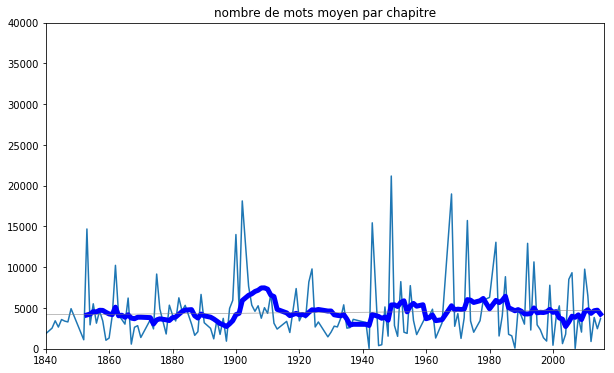

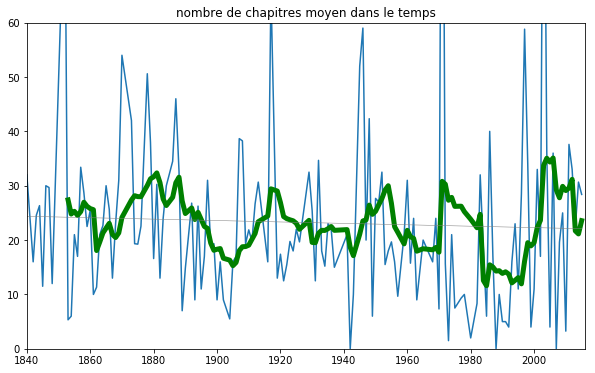

In [48]:
stats_canon=pickle.load(open( "stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['b','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

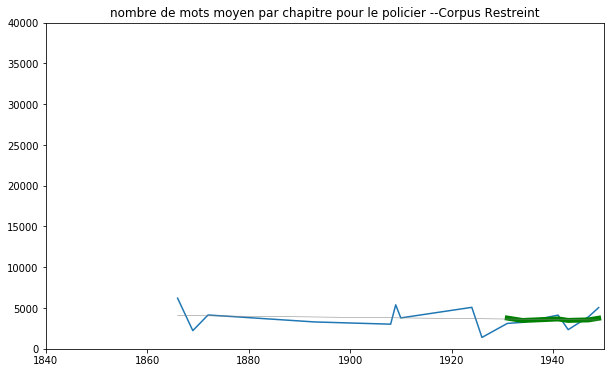

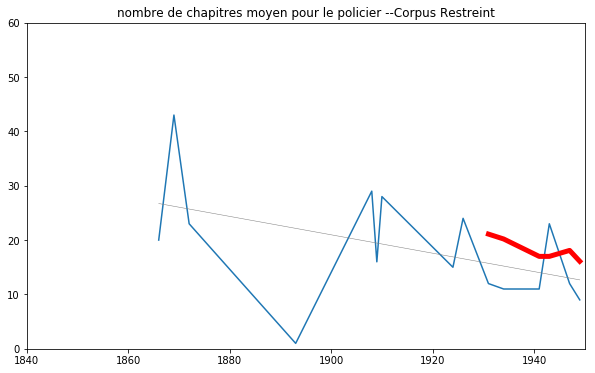

In [108]:
stats_canon=pickle.load(open( "stats_rest_policier", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour le policier --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour le policier --Corpus Restreint")

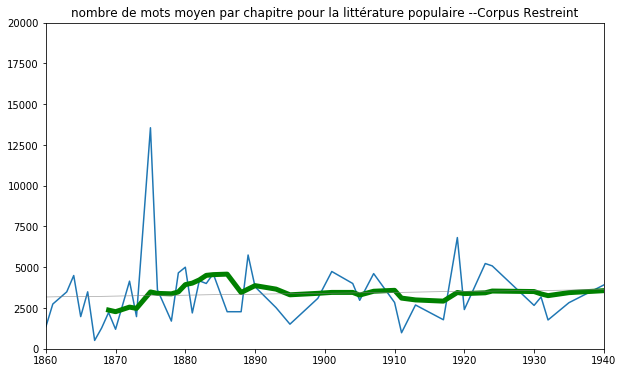

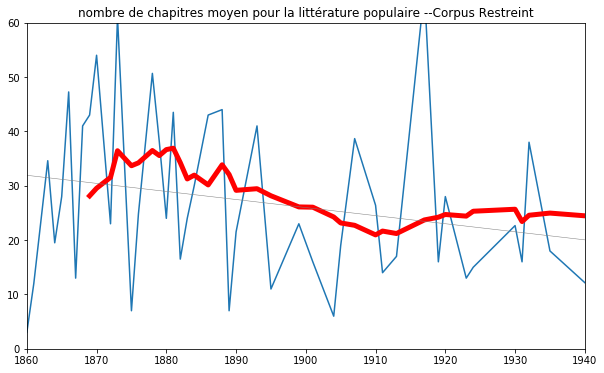

In [17]:
stats_canon=pickle.load(open( "stats_rest_populaire", "rb"))
limitsX=[1860,1940]
limitsWord=[0,20000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Restreint")

odict_keys(['_Dumas', '_Zola', '_Guy-de-Maupassant', '_Sand-G', '_Simenon', '_San-Antonio', '_Leblanc'])


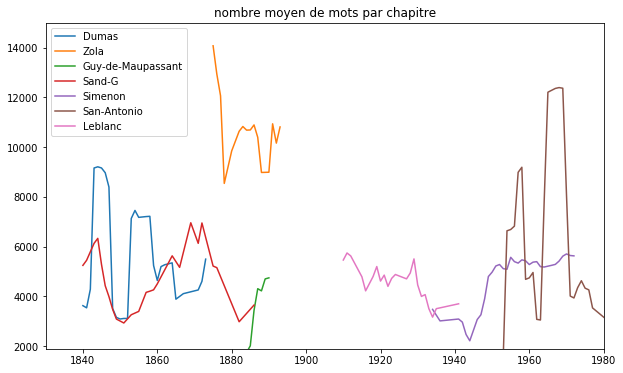

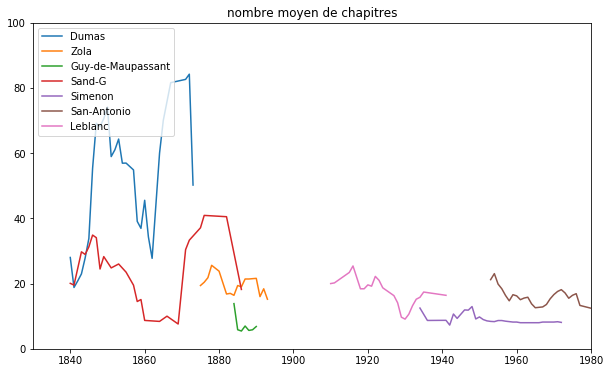

In [37]:
stats_authors=pickle.load(open("stats_authors","rb"))
print(stats_authors.keys())
multiple_plots(1830,1980, 15000,100,stats_authors)

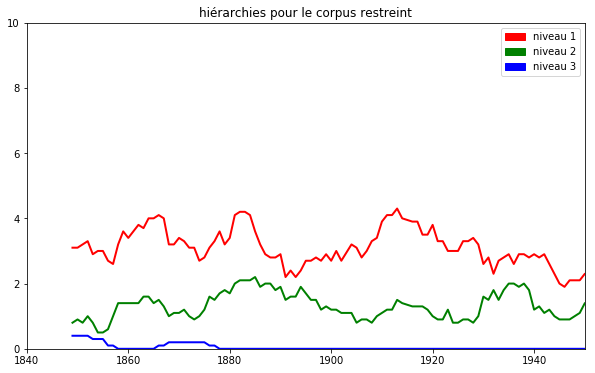

In [41]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,1950]
limitsWord=[0,10]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus restreint")

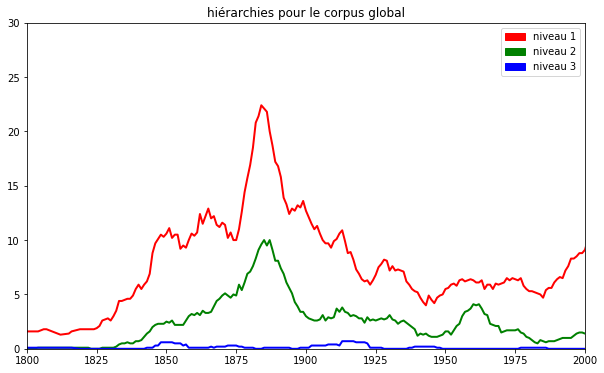

In [57]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1800,2000]
limitsWord=[0,30]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus global")

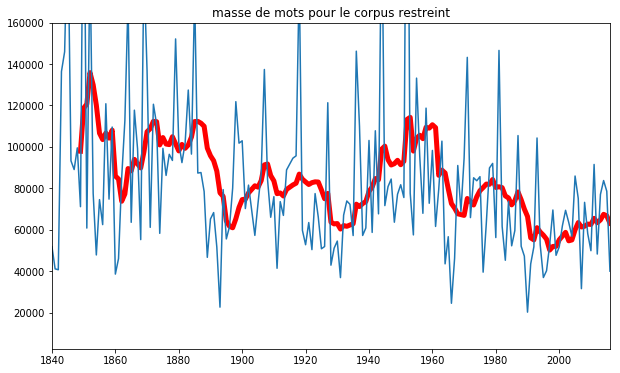

In [42]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,160000]
color='r'
sliding=10
simple_plot(stats_global["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint")

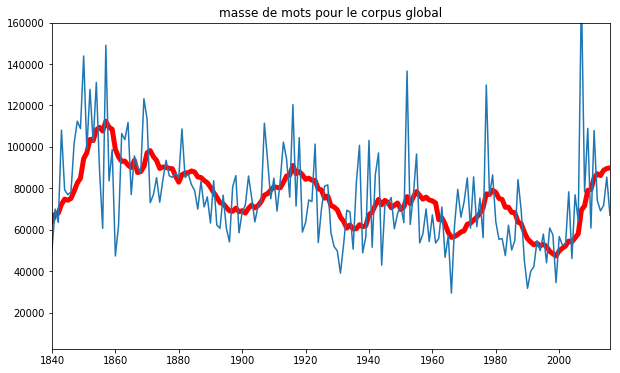

In [65]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,160000]
color='r'
sliding=10
simple_plot(stats_global["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus global")

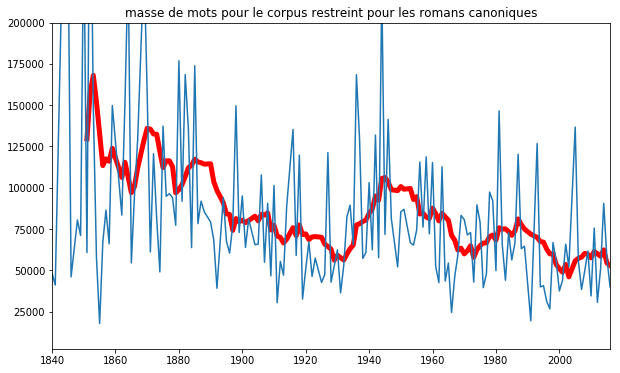

In [43]:
stats_canon=pickle.load(open("stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans canoniques")

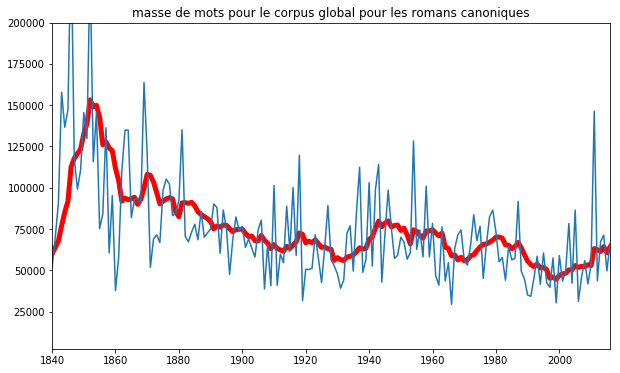

In [66]:
stats_canon=pickle.load(open("stats_global_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus global pour les romans canoniques")

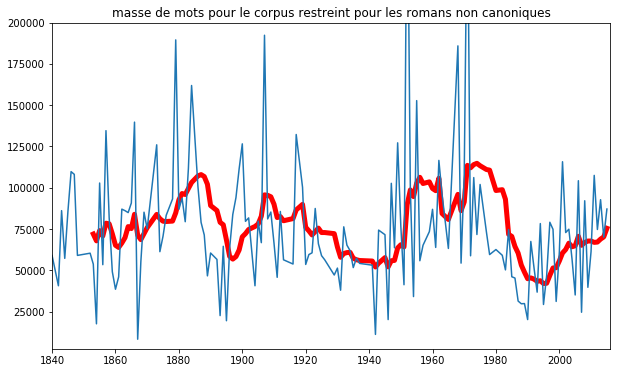

In [49]:
stats_non_canon=pickle.load(open("stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_non_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans non canoniques")

In [ ]:
stats_non_canon=pickle.load(open("stats_global_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_non_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus global pour les romans non canoniques")

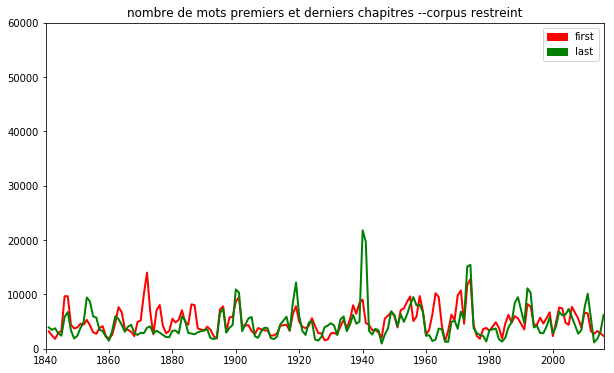

In [44]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint")

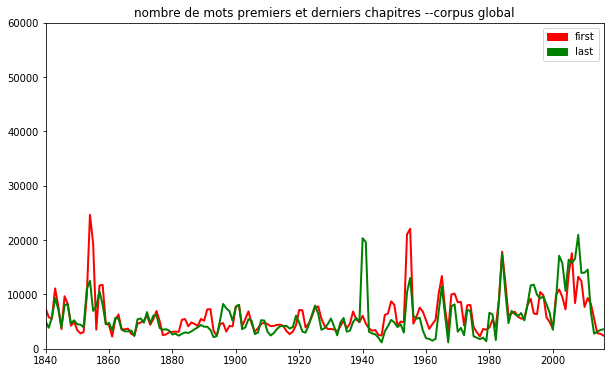

In [64]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus global")

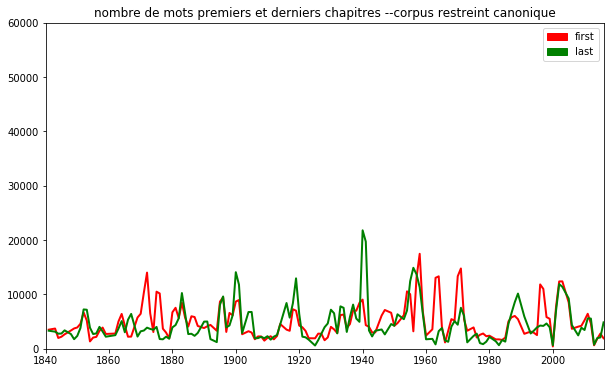

In [45]:
stats_global=pickle.load(open( "stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint canonique")

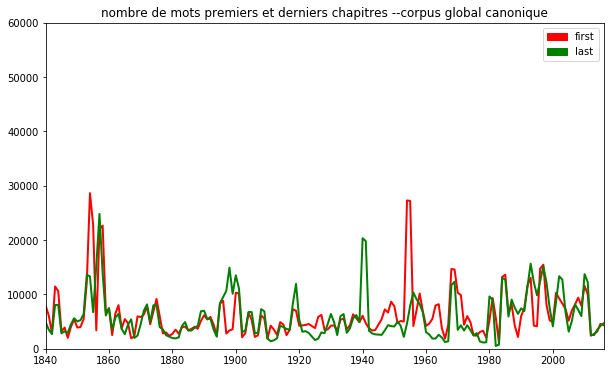

In [63]:
stats_global=pickle.load(open( "stats_global_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus global canonique")

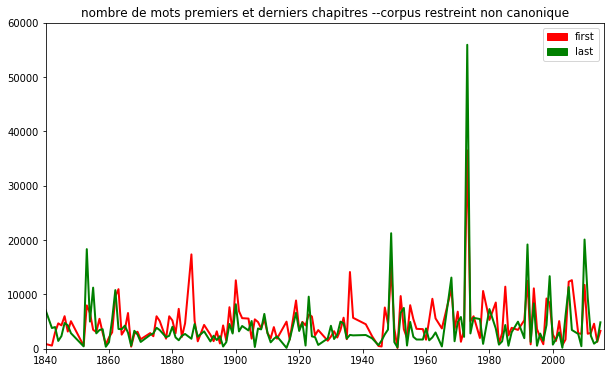

In [50]:
stats_global=pickle.load(open( "stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=1
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint non canonique")

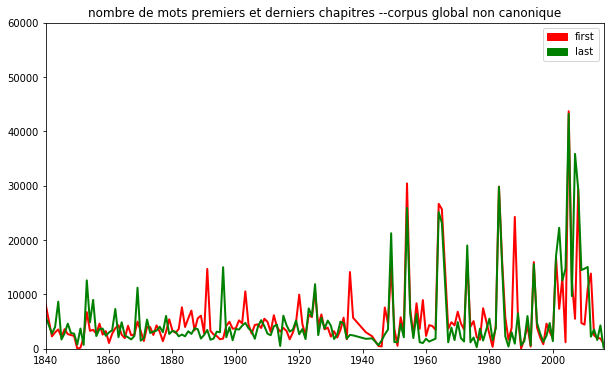

In [62]:
stats_global=pickle.load(open( "stats_global_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=1
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus global non canonique")

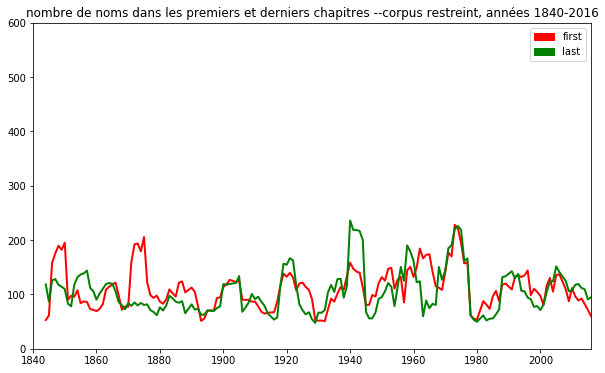

In [46]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,600]
color=['r','g']
sliding=5
first_n_last_plots(stats_global["ents"],limitsX,limitsWord, sliding, color, "nombre de noms dans les premiers et derniers chapitres --corpus restreint, années 1840-2016")

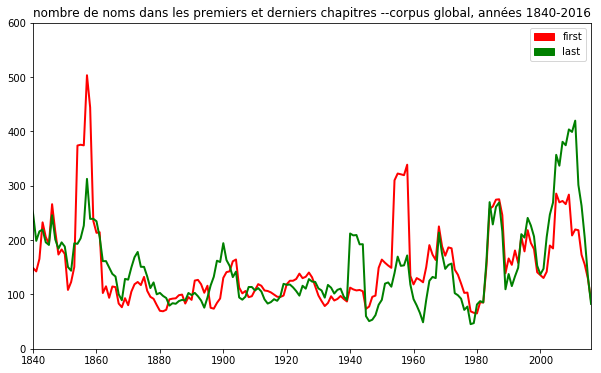

In [61]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[0,600]
color=['r','g']
sliding=5
first_n_last_plots(stats_global["ents"],limitsX,limitsWord, sliding, color, "nombre de noms dans les premiers et derniers chapitres --corpus global, années 1840-2016")